In [1]:
# Example of triangular sparse matrix generation
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

Создаем матрицу

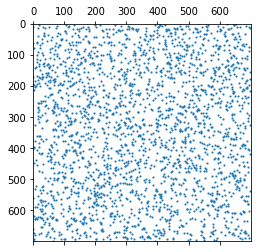

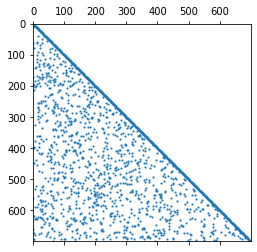

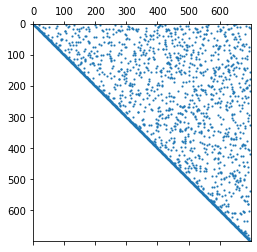

In [35]:
n = 700
A = spsp.rand(n, n, density=0.005).tocsc()
plt.spy(A, markersize=1)
plt.show()
L = spsp.tril(A) + spsp.eye(n)
U = spsp.triu(A) + spsp.eye(n)
plt.spy(L, markersize=1)
plt.show()
plt.spy(U, markersize=1)
plt.show()


(5 pts) Реализуйте классический метод решения треугольной линейной системы, однако учтите, что матрица у вас разреженная. Какой формат хранения разреженной матрицы будет предпочтительным для такого метода решения?



Создадим вектор x и вектор b. \\
LUx = b

In [36]:
import time

In [37]:
x = np.random.rand(n)
b = L @ U @ x

L и U уже обладают типом scipy.sparse.csr.csr_matrix.

Найдем решение для правой части равной b

In [67]:
y = np.zeros(n)
start_time = time.time()
for i in range(len(b)):
  y[i] = (b[i] - L[i] @ y)/L[i, i]

ans = np.zeros(n)
for i in range(len(b)):
  ans[n-1-i] = (y[n-1-i] - U[n-1-i] @ ans) / U[n-1-i, n-1-i]
print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.19438481330871582


Сравними полученное решение ans с эталонным решением x

In [39]:
print(np.linalg.norm(ans-x))

1.352192336032887e-14


Видим, что ошибка мала

Для разряженной матрицы будет предпочтителен метод хранения в виде CSС. Т.к. благодаря этому методу мы можем сократить количество умножений: мы будем умножать только ненулевые значения матрицы, что заметно ускорит работу.

(10 pts) В пункте выше не предполагались никакие специфичные свойства правой части. Однако если предположить, что правая часть является разреженным вектором, то можно предложить более эффективный метод решения такой линейной системы. Основная идея состоит в том, чтобы преобразовать метод из предыдущего пункта из построчного заполнения решения в итерирование по столбцам матрицы и соответствующего обновления решения. Какой формат хранения матрицы является предпочтительным для такого метода решения? Перепишите метод из предыдущего пункта, так чтобы итерирование происходило по столбцам матрицы, и реализуйте его.

Если предпложить, что права часть является разряженным вектором, то можно ускроить алгоритм нахождения решения. Планируем брать диагональные элементы нижнетрегуольных матриц и первый элемент решения b. Если первый элемент равен 0, значит и соответсвующий элемент вектора решения тоже равен 0.  

$$
L = 
\begin{bmatrix} 
l_{11} & 0 \\ l & L_2 \\ 
\end{bmatrix}
$$ \\
$$
\begin{bmatrix} 
l_{11} & 0 \\ l & L_2 \\ 
\end{bmatrix}
*
\begin{bmatrix} 
x_1\\ x_2\\ 
\end{bmatrix}
=
\begin{bmatrix} 
b_1\\ b_2\\ 
\end{bmatrix}
$$ \\
$$
\begin{cases}
l_{11}x_1=b_1\\ 
L_2x_2=b_2-lx_1
\end{cases}
$$ \\
Получили систему, решая которую сможем найти решение $x$. Если $b_1 = 0$, то $x_1 = 0$, следовательно $b_2$ не изменится и нам не придется совршать лишние произведения. \\
Далее рекурсивно решаем для $L_2$.

Для верхнетруегольных матриц решение по логике будет аналогичным. Толькко будем находить решения снизу вверх \\
$$
U = 
\begin{bmatrix} 
U_2 & u \\ 0 & u_{nn} \\ 
\end{bmatrix}
$$ \\
$$
\begin{bmatrix} 
U_2 & u \\ 0 & u_{nn} \\ 
\end{bmatrix}
*
\begin{bmatrix} 
x_2\\ x_1\\ 
\end{bmatrix}
=
\begin{bmatrix} 
b_2\\ b_1\\ 
\end{bmatrix}
$$ \\
$$
\begin{cases}
u_{nn}x_1=b_1\\ 
U_2x_2=b_2-ux_1
\end{cases}
$$ \\


Реализуем в данном пункте наш алгоритм. Будем использовать те же входные данные, что и в первом пункте

In [72]:
y2 = b.copy()
tmp_l = L.copy().tocsc()
start_time = time.time()
for i in range(len(b)):
  if y2[i]:
    y2[i] = y2[i] / tmp_l[i, i]
    for q in range(tmp_l.indptr[i] + 1, tmp_l.indptr[i+1]):
      y2[tmp_l.indices[q]] -= tmp_l.data[q] * y2[i]


ans2 = np.zeros(n)
tmp_u = U.copy().tocsc()
for i in range(len(b)):
  if y2[n - i - 1] == 0:
    ans2[n - i -1] = 0
  else:
    ans2[n - i - 1] = y2[n - i - 1] / tmp_u[n - i - 1, n - i - 1]
    for q in range(tmp_u.indptr[n - i - 1], tmp_u.indptr[n - i]):
      y2[tmp_u.indices[q]] -= tmp_u.data[q]*ans2[n - i - 1] 


print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.064971923828125


Сравним наш результат с эталонным решением

In [41]:
print(np.linalg.norm(ans2-x))

1.4592932812797018e-14


Видим, что ошибка мала

Данный алгоритм нахождения решений более выгодный чем предыдущий. Как пример, новый алгоритм совершает меньшее количество действий во время вычисления решения для нижнетругольной матрицы на шаге $y_i = b_i - \sum_{p=1}^{i-1}l_{ip}y_{p}$. Т.к. в новом алгоритме нам не приходится умножать на нулевые $y_p$. Даёт выгрыш пропорциональный количеству нулевых $b_i$.

Выгоднее опять же использовать CSС, т.к. L и U разреженные

(15 pts) Дальнейшим развитием является предположение, что помимо разреженной правой части само решения также является разреженным. В этом случае можно дополнительно ускорить метод, если рассматривать не все столбцы матрицы, а только те, что действительно влияют на заполненность решения. Для определения таких столбцов необходимо выяснить какие элементы решения окажутся ненулевыми, если в правой части есть ненулевой элемент на позиции ? Для ответа на этот вопрос вам поможет графовая интерпретация разреженной матрицы и понятие топологической сортировки. Реализуйте метод решения треугольной разреженной системы в таких предположениях.

В данном пункте будем делать поиск ненулевых значений "x" до их подсчета. Благодаря этому мы сможем сэкономить на времени исполнения алгоритма, благодаря тому, что мы не будем лишний раз умножать на нули. Как было в цикле пункта 2:  "for i in range(len(b)):"

Исходя из логики второго пункта, мы при нахождении значения $x_1$, совершаем дейсвтие $L_2x_2=b_2-lx_1$. Можно заметить, что если в столбце $l$ существуют ненулевые элементы, которые мы умножим на значение $x_1 \neq 0$. То в решении $b_2$ появятся ненулевые значения на местах с ненулевыми элементами столбца $l$ с большой долей вероятности они будут появляться именно в этих строках $b_2$, т.к. наша матрица составлена из рандомных значений

Поэтому мы можем заранее узнать все ненулевые $x$. Начиная с первого столбца матрицы $A$ будем искать ненулевое значение в строке $b$, как только мы его найдем, то сразу придется искать ненулевые значение в столбце матрицы $A$, для которого было найдено ненулевое значение $b$. Далее рекурсивно проходя будем находить все остальные ненулевые значения $x$. При построении графа, состоящего из вершин $x$, у нас может получиться несвязный граф. Мы будем преодолевать эту проблему: если при рекурсивном обходе больше не будет находится ненулевых значений в столбцах, то вернремся к столбцу, с которого начали рекурсивное исследование матрицы и продолжим исследованеие матрицы уже со следущего столбца(учитвая пройденные $x$).

In [68]:
def make_graph(A, j, targeted, outp):
  targeted[j] = 1
  for i in range(A.indptr[j], A.indptr[j + 1]):
    if targeted[A.indices[i]] == 0:
      make_graph(A, A.indices[i], targeted, outp)
  outp.append(j)


def find_nonzero(A, b, targeted):
  iterate = np.arange(len(b))
  iterate = iterate[b != 0]
  outp = []
  for i in iterate:
    if targeted[i] == 0:
      make_graph(A, i, targeted, outp)
  return outp


y3 = b.copy()
lst = np.zeros(n)
tmp_l = L.copy().tocsc()
start_time = time.time()
Non_zero = find_nonzero(tmp_l, b, lst)
for i in list(reversed(Non_zero)):
  if y3[i]:
    y3[i] = y3[i] / tmp_l[i, i]
    for q in range(tmp_l.indptr[i] + 1, tmp_l.indptr[i+1]):
      y3[tmp_l.indices[q]] -= tmp_l.data[q] * y3[i]

lst = np.zeros(n)
ans3 = np.zeros(n)
tmp_u = U.copy().tocsc()
Non_zero = find_nonzero(tmp_u, b, lst)
for i in Non_zero:
  if y3[n - i - 1] == 0:
    ans3[n - i -1] = 0
  else:
    ans3[n - i - 1] = y3[n - i - 1] / tmp_u[n - i - 1, n - i - 1]
    for q in range(tmp_u.indptr[n - i - 1], tmp_u.indptr[n - i]):
      y3[tmp_u.indices[q]] -= tmp_u.data[q]*ans3[n - i - 1] 

print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.049320220947265625


In [65]:
print(np.linalg.norm(ans3-x))

1.3978041817200142e-14


Видим, что ошибка мала

(10 pts) Проведите сравнение реализованных выше методов на разреженных треугольных (верхне и нижне) матрицах и правых частях удовлестворяющих перечисленным выше свойствам. Экспериментально проверьте, в каких случаях, какой метод является предпочтительным. Приведите теоретическую оценку сложности каждого из методов.

Мы уже засекали время для нахождения решений с плотными $b$ и $x$. И можно сделать вывод, что пункт 2 по сравнению с пунком 1 даёт большйо выигрышь в скорости. А пункт 2 и 3 при плотном значении $b$ не даёт ощутимого превосходства на пунктом 2

Проведем эксперементы с разреженными $b$

In [91]:
b = np.zeros(n - 20)
q = np.arange(20)
b = np.append(b, q)
np.random.shuffle(b)


Замерим для пункта 1

In [88]:
y = np.zeros(n)
start_time = time.time()
for i in range(len(b)):
  y[i] = (b[i] - L[i] @ y)/L[i, i]

ans = np.zeros(n)
for i in range(len(b)):
  ans[n-1-i] = (y[n-1-i] - U[n-1-i] @ ans) / U[n-1-i, n-1-i]
print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.18074655532836914


Замерим для пункта 2

In [89]:
y2 = b.copy()
tmp_l = L.copy().tocsc()
start_time = time.time()
for i in range(len(b)):
  if y2[i]:
    y2[i] = y2[i] / tmp_l[i, i]
    for q in range(tmp_l.indptr[i] + 1, tmp_l.indptr[i+1]):
      y2[tmp_l.indices[q]] -= tmp_l.data[q] * y2[i]


ans2 = np.zeros(n)
tmp_u = U.copy().tocsc()
for i in range(len(b)):
  if y2[n - i - 1] == 0:
    ans2[n - i -1] = 0
  else:
    ans2[n - i - 1] = y2[n - i - 1] / tmp_u[n - i - 1, n - i - 1]
    for q in range(tmp_u.indptr[n - i - 1], tmp_u.indptr[n - i]):
      y2[tmp_u.indices[q]] -= tmp_u.data[q]*ans2[n - i - 1] 


print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.026428699493408203


Замерим для пункта 3

In [90]:
def make_graph(A, j, targeted, outp):
  targeted[j] = 1
  for i in range(A.indptr[j], A.indptr[j + 1]):
    if targeted[A.indices[i]] == 0:
      make_graph(A, A.indices[i], targeted, outp)
  outp.append(j)


def find_nonzero(A, b, targeted):
  iterate = np.arange(len(b))
  iterate = iterate[b != 0]
  outp = []
  for i in iterate:
    if targeted[i] == 0:
      make_graph(A, i, targeted, outp)
  return outp


y3 = b.copy()
lst = np.zeros(n)
tmp_l = L.copy().tocsc()
start_time = time.time()
Non_zero = find_nonzero(tmp_l, b, lst)
for i in list(reversed(Non_zero)):
  if y3[i]:
    y3[i] = y3[i] / tmp_l[i, i]
    for q in range(tmp_l.indptr[i] + 1, tmp_l.indptr[i+1]):
      y3[tmp_l.indices[q]] -= tmp_l.data[q] * y3[i]

lst = np.zeros(n)
ans3 = np.zeros(n)
tmp_u = U.copy().tocsc()
Non_zero = find_nonzero(tmp_u, b, lst)
for i in Non_zero:
  if y3[n - i - 1] == 0:
    ans3[n - i -1] = 0
  else:
    ans3[n - i - 1] = y3[n - i - 1] / tmp_u[n - i - 1, n - i - 1]
    for q in range(tmp_u.indptr[n - i - 1], tmp_u.indptr[n - i]):
      y3[tmp_u.indices[q]] -= tmp_u.data[q]*ans3[n - i - 1] 

print("Время выполнения")
print(time.time() - start_time)

Время выполнения
0.007623434066772461


Как и ожидолось пункт 1 оказался самым неэффективным. Пункт 2 оказался быстрее, т.к. он способен быстрее рабоатть с разреженным $b$. А пункт 3 превзошёл пункт 2, т.к. в нем мы ещё сильнее ускороиили наш алгоритм, учитывая что решение $x$ также будет разреженным

Для первого алгоритма сложность $n2$. Для 2) $n * кол-во ненулевых b$. Для 3 пункта $n * кол-во ненулевых b * долю ненулевых х$ 